### Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf

import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error as mse
from keras.losses import MeanAbsolutePercentageError

from keras.initializers import RandomUniform

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

### Import Dataset

In [2]:
df = pd.read_csv('data/data_vitb.csv')

### EDA

In [3]:
# Convert Dataset into DataFrame
# dataset = pd.DataFrame(dataset)
df.head()

,Month,Use_VitBComplex
0,2015-01-01,2457
1,2015-02-01,2356
2,2015-03-01,2437
3,2015-04-01,2512
4,2015-05-01,2345


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Month            84 non-null     object
 1   Use_VitBComplex  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df.isna().sum()

Month              0
Use_VitBComplex    0
dtype: int64

In [6]:
df.describe()

,Use_VitBComplex
count,84.000000
mean,2469.380952
std,113.577626
min,2234.000000
25%,2363.250000
50%,2455.000000
75%,2561.750000
max,2732.000000


In [7]:
df['Month'] = pd.to_datetime(df['Month']).dt.date
df.head()

,Month,Use_VitBComplex
0,2015-01-01,2457
1,2015-02-01,2356
2,2015-03-01,2437
3,2015-04-01,2512
4,2015-05-01,2345


In [8]:
plot = px.line(df, x=df.Month, y=df.Use_VitBComplex)
plot.show()

In [9]:
plot = px.histogram(df, x=df.Use_VitBComplex, marginal='box')
plot.show()

### Data Preprocessing

In [10]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [11]:
df.set_index('Month', inplace=True)
df.head()

,Use_VitBComplex
Month,
2015-01,2457
2015-02,2356
2015-03,2437
2015-04,2512
2015-05,2345


In [12]:
df = df.values

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.44779116],
       [0.24497992],
       [0.40763052],
       [0.55823293],
       [0.22289157],
       [0.29518072],
       [0.60441767],
       [0.47188755],
       [0.84337349],
       [0.40361446],
       [0.82128514],
       [0.44578313],
       [0.23092369],
       [0.35542169],
       [0.42168675],
       [0.46385542],
       [0.8253012 ],
       [0.937751  ],
       [0.6686747 ],
       [0.2248996 ],
       [0.08835341],
       [0.26506024],
       [0.36947791],
       [0.47188755],
       [0.82128514],
       [0.39558233],
       [0.2188755 ],
       [0.41967871],
       [0.55823293],
       [0.41164659],
       [0.40562249],
       [0.35542169],
       [0.89156627],
       [0.6686747 ],
       [0.1746988 ],
       [0.41767068],
       [0.62048193],
       [0.47791165],
       [0.22891566],
       [0.66465863],
       [0.67269076],
       [0.24497992],
       [0.46787149],
       [0.39156627],
       [0.65662651],
       [0.52008032],
       [0.6626506 ],
       [0.483

In [14]:
train_size = int(len(df) * 0.8)
test_size = (len(df)) - train_size
print(train_size, test_size)

67 17


In [15]:
train , test = df[0:train_size,:] , df[train_size:len(df),:]

In [16]:
def to_sequences(df, seq_size):
    x = []
    y = []

    for i in range(len(df)-seq_size):
        window = df[i:(i+seq_size), 0]
        x.append(window)
        y.append(df[i+seq_size, 0])

    return np.array(x), np.array(y)

In [17]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of testinf set: {}".format(testX.shape))

Shape of training set: (62, 5)
Shape of testinf set: (12, 5)


In [18]:
mape = MeanAbsolutePercentageError()

### Model 1

In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model1.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model1.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=6)

model1.evaluate(testX, testY)


1/1 [==============================] - 0s 127ms/step - loss: 0.0550 - mean_absolute_error: 0.1977


[0.054983604699373245, 0.19768507778644562]

In [20]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse = scaler.inverse_transform([testY])

print('Model 1')

trainScore1 = math.sqrt(mse(trainY_inverse[0], trainPredict1[:,0]))
print('Train score: %.2f' % (trainScore1))

testScore1 = math.sqrt(mse(testY_inverse[0], testPredict1[:,0]))
print('Test score: %.2f' % (testScore1))

1/1 [==============================] - 0s 34ms/step
Model 1
Train score: 99.95
Test score: 116.77


In [21]:
mapeTrain1 = mape(trainY_inverse, trainPredict1)
print('MAPE Train   :  ', mapeTrain1.numpy())
print('Akurasi Train: ', 100 - (mapeTrain1.numpy()))

mape1 = mape(testY_inverse, testPredict1)
print('MAPE Test    :  ', mape1.numpy())
print('Akurasi Test : ', 100 - (mape1.numpy()))

MAPE Train   :   4.347767
Akurasi Train:  95.6522331237793
MAPE Test    :   4.238868
Akurasi Test :  95.76113176345825


### Model 2

In [22]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model2.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=6)

model2.evaluate(testX, testY)


1/1 [==============================] - 0s 171ms/step - loss: 0.0605 - mean_absolute_error: 0.2091


[0.06047431752085686, 0.20913280546665192]

In [23]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict2 = scaler.inverse_transform(testPredict2)
testY_inverse = scaler.inverse_transform([testY])

print('Model 2')

trainScore2 = math.sqrt(mse(trainY_inverse[0], trainPredict2[:,0]))
print('Train score: %.2f' % (trainScore2))

testScore2 = math.sqrt(mse(testY_inverse[0], testPredict2[:,0]))
print('Test score: %.2f' % (testScore2))

1/1 [==============================] - 0s 29ms/step
Model 2
Train score: 94.52
Test score: 122.47


In [24]:
mapeTrain2 = mape(trainY_inverse, trainPredict2)
print('MAPE Train: ', mapeTrain2.numpy())
print('Akurasi Train: ', 100 - (mapeTrain2.numpy()))

mape2 = mape(testY_inverse, testPredict2)
print('MAPE Test: ', mape2.numpy())
print('Akurasi Test: ', 100 - (mape2.numpy()))

MAPE Train:  4.3944154
Akurasi Train:  95.60558462142944
MAPE Test:  4.187177
Akurasi Test:  95.8128228187561


### Model 3

In [25]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model3.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=6)

model3.evaluate(testX, testY)


1/1 [==============================] - 0s 118ms/step - loss: 0.0578 - mean_absolute_error: 0.2110


[0.057763803750276566, 0.21100620925426483]

In [26]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

trainPredict3 = scaler.inverse_transform(trainPredict3)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict3 = scaler.inverse_transform(testPredict3)
testY_inverse = scaler.inverse_transform([testY])

print('Model 3')

trainScore3 = math.sqrt(mse(trainY_inverse[0], trainPredict3[:,0]))
print('Train score: %.2f' % (trainScore3))

testScore3 = math.sqrt(mse(testY_inverse[0], testPredict3[:,0]))
print('Test score: %.2f' % (testScore3))

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 37ms/step
Model 3
Train score: 89.13
Test score: 119.69


In [27]:
mapeTrain3 = mape(trainY_inverse, trainPredict3)
print('MAPE Train: ', mapeTrain3.numpy())
print('Akurasi Train: ', 100 - (mapeTrain3.numpy()))

mape3 = mape(testY_inverse, testPredict3)
print('MAPE Test: ', mape3.numpy())
print('Akurasi Test: ', 100 - (mape3.numpy()))

MAPE Train:  4.435261
Akurasi Train:  95.56473922729492
MAPE Test:  4.1726575
Akurasi Test:  95.82734251022339


### Model 4

In [28]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model4.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model4.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=6)

model4.evaluate(testX, testY)


1/1 [==============================] - 0s 118ms/step - loss: 0.0846 - mean_absolute_error: 0.2456


[0.08460984379053116, 0.24562187492847443]

In [29]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)

trainPredict4 = scaler.inverse_transform(trainPredict4)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict4 = scaler.inverse_transform(testPredict4)
testY_inverse = scaler.inverse_transform([testY])

print('Model 4')

trainScore4 = math.sqrt(mse(trainY_inverse[0], trainPredict4[:,0]))
print('Train score: %.2f' % (trainScore4))

testScore4 = math.sqrt(mse(testY_inverse[0], testPredict4[:,0]))
print('Test score: %.2f' % (testScore4))

1/1 [==============================] - 0s 24ms/step
Model 4
Train score: 69.37
Test score: 144.86


In [30]:
mapeTrain4 = mape(trainY_inverse, trainPredict4)
print('MAPE Train: ', mapeTrain4.numpy())
print('Akurasi Train: ', 100 - (mapeTrain4.numpy()))

mape4 = mape(testY_inverse, testPredict4)
print('MAPE Test: ', mape4.numpy())
print('Akurasi Test: ', 100 - (mape4.numpy()))

MAPE Train:  4.659229
Akurasi Train:  95.3407711982727
MAPE Test:  4.223747
Akurasi Test:  95.77625322341919


### Model 5

In [31]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model5.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=6)

model5.evaluate(testX, testY)


1/1 [==============================] - 0s 116ms/step - loss: 0.0888 - mean_absolute_error: 0.2555


[0.08883442729711533, 0.25549396872520447]

In [32]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)

trainPredict5 = scaler.inverse_transform(trainPredict5)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict5 = scaler.inverse_transform(testPredict5)
testY_inverse = scaler.inverse_transform([testY])

print('Model 5')

trainScore5 = math.sqrt(mse(trainY_inverse[0], trainPredict5[:,0]))
print('Train score: %.2f' % (trainScore5))

testScore5 = math.sqrt(mse(testY_inverse[0], testPredict5[:,0]))
print('Test score: %.2f' % (testScore5))

1/1 [==============================] - 0s 29ms/step
Model 5
Train score: 70.49
Test score: 148.43


In [33]:
mapeTrain5 = mape(trainY_inverse, trainPredict5)
print('MAPE Train: ', mapeTrain5.numpy())
print('Akurasi Train: ', 100 - (mapeTrain5.numpy()))

mape5 = mape(testY_inverse, testPredict5)
print('MAPE Test: ', mape5.numpy())
print('Akurasi Test: ', 100 - (mape5.numpy()))

MAPE Train:  4.6836414
Akurasi Train:  95.31635856628418
MAPE Test:  4.5481286
Akurasi Test:  95.45187139511108


### Model 6

In [34]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model6.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=6)

model6.evaluate(testX, testY)


1/1 [==============================] - 0s 110ms/step - loss: 0.0627 - mean_absolute_error: 0.2165


[0.06266997009515762, 0.216500923037529]

In [35]:
trainPredict6 = model6.predict(trainX)
testPredict6 = model6.predict(testX)

trainPredict6 = scaler.inverse_transform(trainPredict6)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict6 = scaler.inverse_transform(testPredict6)
testY_inverse = scaler.inverse_transform([testY])

print('Model 6')

trainScore6 = math.sqrt(mse(trainY_inverse[0], trainPredict6[:,0]))
print('Train score: %.2f' % (trainScore6))

testScore6 = math.sqrt(mse(testY_inverse[0], testPredict6[:,0]))
print('Test score: %.2f' % (testScore6))

1/1 [==============================] - 0s 22ms/step
Model 6
Train score: 51.59
Test score: 124.67


In [36]:
mapeTrain6 = mape(trainY_inverse, trainPredict6)
print('MAPE Train: ', mapeTrain6.numpy())
print('Akurasi Train: ', 100 - (mapeTrain6.numpy()))

mape6 = mape(testY_inverse, testPredict6)
print('MAPE Test: ', mape6.numpy())
print('Akurasi Test: ', 100 - (mape6.numpy()))

MAPE Train:  4.95447
Akurasi Train:  95.04552984237671
MAPE Test:  4.4813733
Akurasi Test:  95.51862668991089


### Model 7

In [37]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model7.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=8)

model7.evaluate(testX, testY)


1/1 [==============================] - 0s 28ms/step - loss: 0.0492 - mean_absolute_error: 0.1867


[0.04920603707432747, 0.18667729198932648]

In [38]:
trainPredict7 = model7.predict(trainX)
testPredict7 = model7.predict(testX)

trainPredict7 = scaler.inverse_transform(trainPredict7)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict7 = scaler.inverse_transform(testPredict7)
testY_inverse = scaler.inverse_transform([testY])

print('Model 7')

trainScore7 = math.sqrt(mse(trainY_inverse[0], trainPredict7[:,0]))
print('Train score: %.2f' % (trainScore7))

testScore7 = math.sqrt(mse(testY_inverse[0], testPredict7[:,0]))
print('Test score: %.2f' % (testScore7))

1/1 [==============================] - 0s 29ms/step
Model 7
Train score: 102.06
Test score: 110.47


In [39]:
mapeTrain7 = mape(trainY_inverse, trainPredict7)
print('MAPE Train: ', mapeTrain7.numpy())
print('Akurasi Train: ', 100 - (mapeTrain7.numpy()))

mape7 = mape(testY_inverse, testPredict7)
print('MAPE Test: ', mape7.numpy())
print('Akurasi Test: ', 100 - (mape7.numpy()))

MAPE Train:  4.1811886
Akurasi Train:  95.81881141662598
MAPE Test:  3.9623458
Akurasi Test:  96.03765416145325


### Model 8

In [40]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model8.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=8)

model8.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0600 - mean_absolute_error: 0.2219


[0.060007672756910324, 0.2219151258468628]

In [41]:
trainPredict8 = model8.predict(trainX)
testPredict8 = model8.predict(testX)

trainPredict8 = scaler.inverse_transform(trainPredict8)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict8 = scaler.inverse_transform(testPredict8)
testY_inverse = scaler.inverse_transform([testY])

print('Model 8')

trainScore8 = math.sqrt(mse(trainY_inverse[0], trainPredict8[:,0]))
print('Train score: %.2f' % (trainScore8))

testScore8 = math.sqrt(mse(testY_inverse[0], testPredict8[:,0]))
print('Test score: %.2f' % (testScore8))

1/1 [==============================] - 0s 23ms/step
Model 8
Train score: 95.30
Test score: 121.99


In [42]:
mapeTrain8 = mape(trainY_inverse, trainPredict8)
print('MAPE Train: ', mapeTrain8.numpy())
print('Akurasi Train: ', 100 - (mapeTrain8.numpy()))

mape8 = mape(testY_inverse, testPredict8)
print('MAPE Test: ', mape8.numpy())
print('Akurasi Test: ', 100 - (mape8.numpy()))

MAPE Train:  4.355206
Akurasi Train:  95.64479398727417
MAPE Test:  4.124054
Akurasi Test:  95.87594604492188


### Model 9

In [43]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model9.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=8)

model9.evaluate(testX, testY)


1/1 [==============================] - 0s 39ms/step - loss: 0.0736 - mean_absolute_error: 0.2419


[0.07362542301416397, 0.24193455278873444]

In [44]:
trainPredict9 = model9.predict(trainX)
testPredict9 = model9.predict(testX)

trainPredict9 = scaler.inverse_transform(trainPredict9)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict9 = scaler.inverse_transform(testPredict9)
testY_inverse = scaler.inverse_transform([testY])

print('Model 9')

trainScore9 = math.sqrt(mse(trainY_inverse[0], trainPredict9[:,0]))
print('Train score: %.2f' % (trainScore9))

testScore9 = math.sqrt(mse(testY_inverse[0], testPredict9[:,0]))
print('Test score: %.2f' % (testScore9))

1/1 [==============================] - 0s 23ms/step
Model 9
Train score: 84.90
Test score: 135.13


In [45]:
mapeTrain9 = mape(trainY_inverse, trainPredict9)
print('MAPE Train: ', mapeTrain9.numpy())
print('Akurasi Train: ', 100 - (mapeTrain9.numpy()))

mape9 = mape(testY_inverse, testPredict9)
print('MAPE Test: ', mape9.numpy())
print('Akurasi Test: ', 100 - (mape9.numpy()))

MAPE Train:  4.538135
Akurasi Train:  95.4618649482727
MAPE Test:  4.3816614
Akurasi Test:  95.6183385848999


### Model 10

In [46]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model10.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=8)

model10.evaluate(testX, testY)


1/1 [==============================] - 0s 31ms/step - loss: 0.0534 - mean_absolute_error: 0.1956


[0.05336408689618111, 0.19556482136249542]

In [47]:
trainPredict10 = model10.predict(trainX)
testPredict10 = model10.predict(testX)

trainPredict10 = scaler.inverse_transform(trainPredict10)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict10 = scaler.inverse_transform(testPredict10)
testY_inverse = scaler.inverse_transform([testY])

print('Model 10')

trainScore10 = math.sqrt(mse(trainY_inverse[0], trainPredict10[:,0]))
print('Train score: %.2f' % (trainScore10))

testScore10 = math.sqrt(mse(testY_inverse[0], testPredict10[:,0]))
print('Test score: %.2f' % (testScore10))

1/1 [==============================] - 0s 25ms/step
Model 10
Train score: 82.58
Test score: 115.04


In [48]:
mapeTrain10 = mape(trainY_inverse, trainPredict10)
print('MAPE Train: ', mapeTrain10.numpy())
print('Akurasi Train: ', 100 - (mapeTrain10.numpy()))

mape10 = mape(testY_inverse, testPredict10)
print('MAPE Test: ', mape10.numpy())
print('Akurasi Test: ', 100 - (mape10.numpy()))

MAPE Train:  4.567967
Akurasi Train:  95.4320330619812
MAPE Test:  4.0534034
Akurasi Test:  95.94659662246704


### Model 11

In [49]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model11.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model11.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=8)

model11.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0837 - mean_absolute_error: 0.2578


[0.08366783708333969, 0.2578132152557373]

In [50]:
trainPredict11 = model11.predict(trainX)
testPredict11 = model11.predict(testX)

trainPredict11 = scaler.inverse_transform(trainPredict11)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict11 = scaler.inverse_transform(testPredict11)
testY_inverse = scaler.inverse_transform([testY])

print('Model 11')

trainScore11 = math.sqrt(mse(trainY_inverse[0], trainPredict11[:,0]))
print('Train score: %.2f' % (trainScore11))

testScore11 = math.sqrt(mse(testY_inverse[0], testPredict11[:,0]))
print('Test score: %.2f' % (testScore11))

1/1 [==============================] - 0s 24ms/step
Model 11
Train score: 74.10
Test score: 144.05


In [51]:
mapeTrain11 = mape(trainY_inverse, trainPredict11)
print('MAPE Train: ', mapeTrain11.numpy())
print('Akurasi Train: ', 100 - (mapeTrain11.numpy()))

mape11 = mape(testY_inverse, testPredict11)
print('MAPE Test: ', mape11.numpy())
print('Akurasi Test: ', 100 - (mape11.numpy()))

MAPE Train:  4.64393
Akurasi Train:  95.3560700416565
MAPE Test:  4.362976
Akurasi Test:  95.63702392578125


### Model 12

In [52]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model12.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model12.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=8)

model12.evaluate(testX, testY)


1/1 [==============================] - 0s 26ms/step - loss: 0.0987 - mean_absolute_error: 0.2692


[0.09865063428878784, 0.26921546459198]

In [53]:
trainPredict12 = model12.predict(trainX)
testPredict12 = model12.predict(testX)

trainPredict12 = scaler.inverse_transform(trainPredict12)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict12 = scaler.inverse_transform(testPredict12)
testY_inverse = scaler.inverse_transform([testY])

print('Model 12')

trainScore12 = math.sqrt(mse(trainY_inverse[0], trainPredict12[:,0]))
print('Train score: %.2f' % (trainScore12))

testScore12 = math.sqrt(mse(testY_inverse[0], testPredict12[:,0]))
print('Test score: %.2f' % (testScore12))

1/1 [==============================] - 0s 27ms/step
Model 12
Train score: 61.22
Test score: 156.42


In [54]:
mapeTrain12 = mape(trainY_inverse, trainPredict12)
print('MAPE Train: ', mapeTrain12.numpy())
print('Akurasi Train: ', 100 - (mapeTrain12.numpy()))

mape12 = mape(testY_inverse, testPredict12)
print('MAPE : ', mape12.numpy())
print('Akurasi : ', 100 - (mape12.numpy()))

MAPE Train:  4.879574
Akurasi Train:  95.12042617797852
MAPE :  4.9491687
Akurasi :  95.05083131790161


### Model 13

In [55]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model13.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model13.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=12)

model13.evaluate(testX, testY)


1/1 [==============================] - 0s 129ms/step - loss: 0.0622 - mean_absolute_error: 0.2030


[0.06224300339818001, 0.20296256244182587]

In [56]:
trainPredict13 = model13.predict(trainX)
testPredict13 = model13.predict(testX)

trainPredict13 = scaler.inverse_transform(trainPredict13)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict13 = scaler.inverse_transform(testPredict13)
testY_inverse = scaler.inverse_transform([testY])

print('Model 13')

trainScore13 = math.sqrt(mse(trainY_inverse[0], trainPredict13[:,0]))
print('Train score: %.2f' % (trainScore13))

testScore13 = math.sqrt(mse(testY_inverse[0], testPredict13[:,0]))
print('Test score: %.2f' % (testScore13))

1/1 [==============================] - 0s 24ms/step
Model 13
Train score: 107.45
Test score: 124.24


In [57]:
mapeTrain13 = mape(trainY_inverse, trainPredict13)
print('MAPE Train: ', mapeTrain13.numpy())
print('Akurasi Train: ', 100 - (mapeTrain13.numpy()))

mape13 = mape(testY_inverse, testPredict13)
print('MAPE Test: ', mape13.numpy())
print('Akurasi Test: ', 100 - (mape13.numpy()))

MAPE Train:  4.3653073
Akurasi Train:  95.6346926689148
MAPE Test:  4.3591537
Akurasi Test:  95.6408462524414


### Model 14

In [58]:
model14 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model14.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model14.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=12)

model14.evaluate(testX, testY)


1/1 [==============================] - 0s 119ms/step - loss: 0.0446 - mean_absolute_error: 0.1764


[0.04458498954772949, 0.17636306583881378]

In [59]:
trainPredict14 = model14.predict(trainX)
testPredict14 = model14.predict(testX)

trainPredict14 = scaler.inverse_transform(trainPredict14)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict14 = scaler.inverse_transform(testPredict14)
testY_inverse = scaler.inverse_transform([testY])

print('Model 14')

trainScore14 = math.sqrt(mse(trainY_inverse[0], trainPredict14[:,0]))
print('Train score: %.2f' % (trainScore14))

testScore14 = math.sqrt(mse(testY_inverse[0], testPredict14[:,0]))
print('Test score: %.2f' % (testScore14))

1/1 [==============================] - 0s 26ms/step
Model 14
Train score: 103.56
Test score: 105.15


In [60]:
mapeTrain14 = mape(trainY_inverse, trainPredict14)
print('MAPE Train: ', mapeTrain14.numpy())
print('Akurasi Train: ', 100 - (mapeTrain14.numpy()))

mape14 = mape(testY_inverse, testPredict14)
print('MAPE Test: ', mape14.numpy())
print('Akurasi Test: ', 100 - (mape14.numpy()))

MAPE Train:  4.162979
Akurasi Train:  95.83702087402344
MAPE Test:  3.8607855
Akurasi Test:  96.13921451568604


### Model 15

In [61]:
model15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model15.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model15.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model15.evaluate(testX, testY)


1/1 [==============================] - 0s 113ms/step - loss: 0.0565 - mean_absolute_error: 0.2193


[0.05650630220770836, 0.21926188468933105]

In [62]:
trainPredict15 = model15.predict(trainX)
testPredict15 = model15.predict(testX)

trainPredict15 = scaler.inverse_transform(trainPredict15)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict15 = scaler.inverse_transform(testPredict15)
testY_inverse = scaler.inverse_transform([testY])

print('Model 15')

trainScore15 = math.sqrt(mse(trainY_inverse[0], trainPredict15[:,0]))
print('Train score: %.2f' % (trainScore15))

testScore15 = math.sqrt(mse(testY_inverse[0], testPredict15[:,0]))
print('Test score: %.2f' % (testScore15))

1/1 [==============================] - 0s 24ms/step
Model 15
Train score: 93.31
Test score: 118.38


In [63]:
mapeTrain15 = mape(trainY_inverse, trainPredict15)
print('MAPE Train: ', mapeTrain15.numpy())
print('Akurasi Train: ', 100 - (mapeTrain15.numpy()))

mape15 = mape(testY_inverse, testPredict15)
print('MAPE Test: ', mape15.numpy())
print('Akurasi Test: ', 100 - (mape15.numpy()))

MAPE Train:  4.349633
Akurasi Train:  95.65036678314209
MAPE Test:  4.0984206
Akurasi Test:  95.9015793800354


### Model 16

In [64]:
model16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model16.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model16.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=12)

model16.evaluate(testX, testY)


1/1 [==============================] - 0s 117ms/step - loss: 0.0671 - mean_absolute_error: 0.2242


[0.0671333596110344, 0.22423432767391205]

In [65]:
trainPredict16 = model16.predict(trainX)
testPredict16 = model16.predict(testX)

trainPredict16 = scaler.inverse_transform(trainPredict16)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict16 = scaler.inverse_transform(testPredict16)
testY_inverse = scaler.inverse_transform([testY])

print('Model 16')

trainScore16 = math.sqrt(mse(trainY_inverse[0], trainPredict16[:,0]))
print('Train score: %.2f' % (trainScore16))

testScore16 = math.sqrt(mse(testY_inverse[0], testPredict16[:,0]))
print('Test score: %.2f' % (testScore16))

1/1 [==============================] - 0s 23ms/step
Model 16
Train score: 93.58
Test score: 129.03


In [66]:
mapeTrain16 = mape(trainY_inverse, trainPredict16)
print('MAPE Train: ', mapeTrain16.numpy())
print('Akurasi Train: ', 100 - (mapeTrain16.numpy()))

mape16 = mape(testY_inverse, testPredict16)
print('MAPE Test: ', mape16.numpy())
print('Akurasi Test: ', 100 - (mape16.numpy()))

MAPE Train:  4.5638065
Akurasi Train:  95.43619346618652
MAPE Test:  4.476938
Akurasi Test:  95.5230622291565


### Model 17

In [67]:
model17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model17.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model17.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model17.evaluate(testX, testY)


1/1 [==============================] - 0s 122ms/step - loss: 0.0614 - mean_absolute_error: 0.2162


[0.06144048646092415, 0.2162419557571411]

In [68]:
trainPredict17 = model17.predict(trainX)
testPredict17 = model17.predict(testX)

trainPredict17 = scaler.inverse_transform(trainPredict17)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict17 = scaler.inverse_transform(testPredict17)
testY_inverse = scaler.inverse_transform([testY])

print('Model 17')

trainScore17 = math.sqrt(mse(trainY_inverse[0], trainPredict17[:,0]))
print('Train score: %.2f' % (trainScore17))

testScore17 = math.sqrt(mse(testY_inverse[0], testPredict17[:,0]))
print('Test score: %.2f' % (testScore17))

1/1 [==============================] - 0s 24ms/step
Model 17
Train score: 95.73
Test score: 123.44


In [69]:
mapeTrain17 = mape(trainY_inverse, trainPredict17)
print('MAPE Train: ', mapeTrain17.numpy())
print('Akurasi Train: ', 100 - (mapeTrain17.numpy()))

mape17 = mape(testY_inverse, testPredict17)
print('MAPE Test: ', mape17.numpy())
print('Akurasi Test: ', 100 - (mape17.numpy()))

MAPE Train:  4.392208
Akurasi Train:  95.60779190063477
MAPE Test:  4.165302
Akurasi Test:  95.83469820022583


### Model 18

In [70]:
model18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(10, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model18.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model18.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=12)

model18.evaluate(testX, testY)


1/1 [==============================] - 0s 118ms/step - loss: 0.0715 - mean_absolute_error: 0.2318


[0.07148433476686478, 0.23183931410312653]

In [71]:
trainPredict18 = model18.predict(trainX)
testPredict18 = model18.predict(testX)

trainPredict18 = scaler.inverse_transform(trainPredict18)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict18 = scaler.inverse_transform(testPredict18)
testY_inverse = scaler.inverse_transform([testY])

print('Model 18')

trainScore18 = math.sqrt(mse(trainY_inverse[0], trainPredict18[:,0]))
print('Train score: %.2f' % (trainScore18))

testScore18 = math.sqrt(mse(testY_inverse[0], testPredict18[:,0]))
print('Test score: %.2f' % (testScore18))

1/1 [==============================] - 0s 32ms/step
Model 18
Train score: 72.44
Test score: 133.15


In [72]:
mapeTrain18 = mape(trainY_inverse, trainPredict18)
print('MAPE Train: ', mapeTrain18.numpy())
print('Akurasi Train: ', 100 - (mapeTrain18.numpy()))

mape18 = mape(testY_inverse, testPredict18)
print('MAPE Test: ', mape18.numpy())
print('Akurasi Test: ', 100 - (mape18.numpy()))

MAPE Train:  4.6646876
Akurasi Train:  95.3353123664856
MAPE Test:  4.4684253
Akurasi Test:  95.53157472610474


### Model 14 - Use

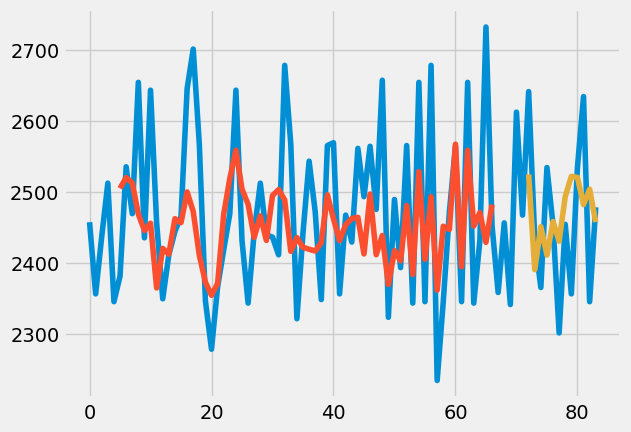

In [73]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict14)+seq_size, :] = trainPredict14

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict14)+(seq_size*2):len(df), :] = testPredict14

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [74]:
# Save Model
save_model = model14.save('model/model_vit.h5',save_format='h5')
save_model

In [77]:
testY_inverse.transpose()

array([[2641.],
       [2434.],
       [2365.],
       [2534.],
       [2453.],
       [2301.],
       [2454.],
       [2356.],
       [2534.],
       [2634.],
       [2345.],
       [2478.]])

In [78]:
testPredict13

array([[2520.331 ],
       [2432.712 ],
       [2508.7188],
       [2415.929 ],
       [2492.3977],
       [2435.428 ],
       [2482.038 ],
       [2518.5325],
       [2492.3164],
       [2478.2126],
       [2528.3599],
       [2455.9766]], dtype=float32)